## Семинар 4: "Сверточные сети"

### Автор: Ракитин Виталий. Техносфера, BD-21.

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [2]:
def t_convolve(signal, kernel):
    new_signal = []
    len_ker = len(kernel)
    len_sig = len(signal)
    for i in xrange(len_sig - len_ker + 1):
        sub_signal = np.array(signal[i : i + len_ker])
        new_signal.append(np.dot(sub_signal, kernel[::-1]))
    return np.array(new_signal)

Проверим правильность реализации, сравнив с реализацией из scipy

In [3]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

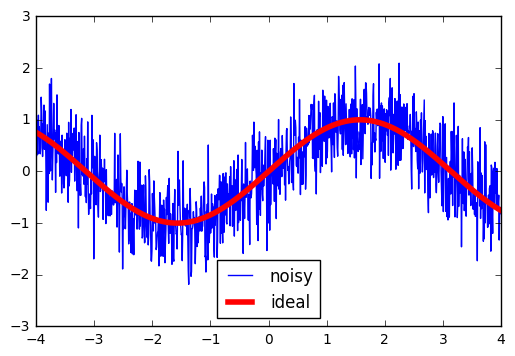

In [4]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [5]:
length = 5
kernel = np.array([1. / length for i in xrange(length)])
denoised_signal = (lambda noisy_signal, kernel: t_convolve(noisy_signal, kernel))

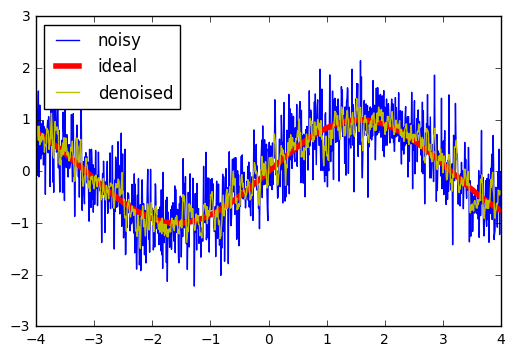

In [6]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x[2:-2], denoised_signal(noisy_signal,kernel), 'y', label='denoised')
plt.legend(loc=0)

Заметим, что уровень шума значительно снизился! Попробуем подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

In [7]:
def correction(signal, noisy_signal):
    length = len(signal)
    minimum_norm = length * length
    pos = 0
    left = 0
    right = 1001
    for i in xrange(1,length):
        if i%2 == 0:
            left += 1
        else: 
            right -= 1
        kernel = np.array([1.0 / i for k in xrange(i)])
        denoised = denoised_signal(noisy_signal,kernel)
        norm = np.linalg.norm((signal[left : right] - denoised)) / (length - i + 1 )
        if norm <  minimum_norm:
            minimum_norm = norm
            pos = i
    return pos

length = correction(signal, noisy_signal)
print "The best approximation is achieved by convolution with size {}.".format(length)

The best approximation is achieved by convolution with size 107.


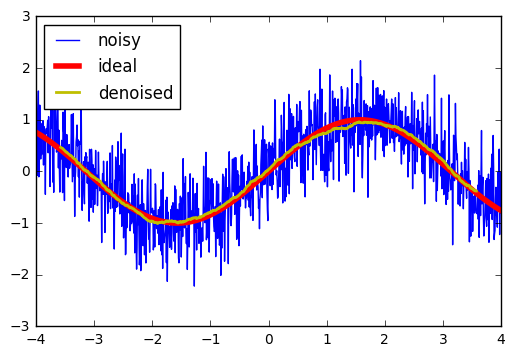

In [8]:
kernel = np.array([1. / length for i in xrange(length)])
left = length / 2
right = length / 2
if length % 2 == 0:
    right -= 1
    
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x[left:-right], denoised_signal(noisy_signal,kernel), 'y', label='denoised', linewidth=2,)
plt.legend(loc=0)

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

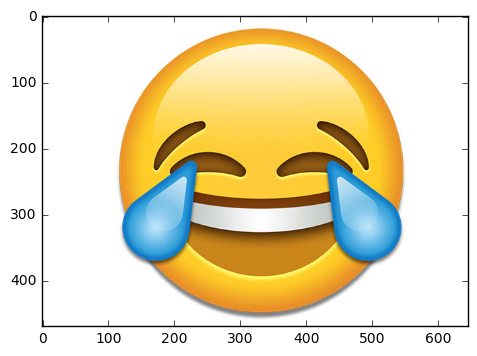

In [9]:
#image = plt.imload('path_to_your_image.jpg')
image = plt.imread('path_to_your_image.jpg')
plt.imshow(image,cmap=plt.cm.Greys_r)

In [10]:
image.shape

(470, 645, 3)

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [11]:
# W = 0.299 R + 0.587 G + 0.114 B
color_to_bw = np.array([0.299, 0.587, 0.114])[::-1].reshape((1,1,3))

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

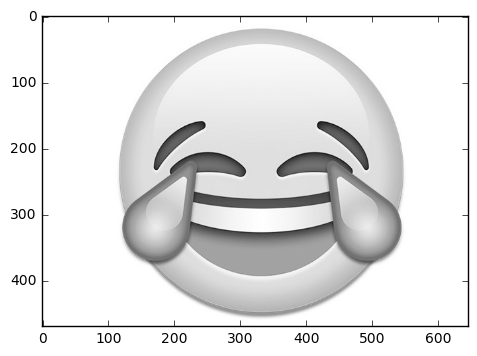

In [12]:
# Не забудьте, что размер bw_image должен быть [w,h], а convolve вам вернет [w,h,1]
bw_image = convolve(image,color_to_bw, mode='valid')[:,:,0]
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро фильтра Собеля и продемонстрируйте результат его применения к любому цветному изображению.</i>

In [13]:
#https://en.wikipedia.org/wiki/Sobel_operator
Gx = np.array([[[1,0,-1],[2,0,-2],[1,0,-1]]]) 
Gy = np.array([[[1,2,1],[0,0,0],[-1,-2,-1]]])

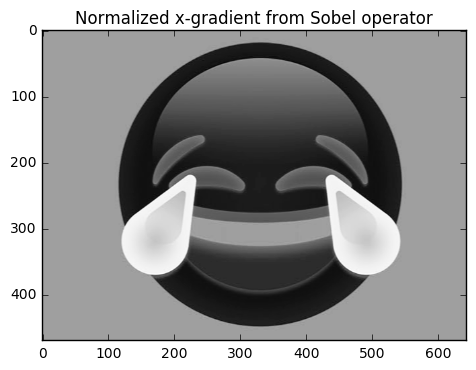

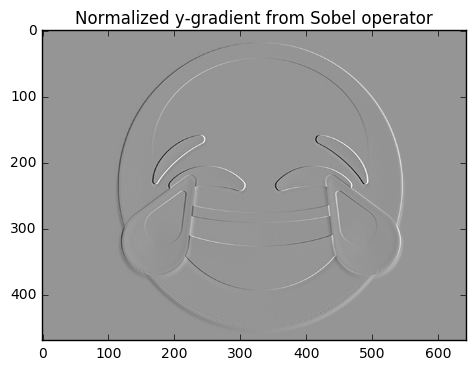

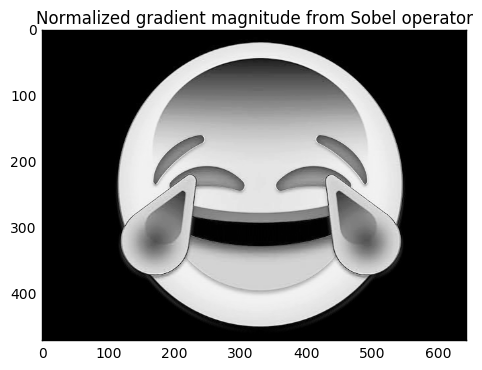

In [14]:
Gx_image = convolve(image, Gx, mode='valid')[:,:,0]
Gy_image = convolve(image, Gy, mode='valid')[:,:,0]
G_image = np.sqrt(Gx_image * Gx_image + Gy_image * Gy_image)

plt.imshow(Gx_image, cmap=plt.cm.Greys_r)
plt.title("Normalized x-gradient from Sobel operator")
plt.show()
plt.imshow(Gy_image, cmap=plt.cm.Greys_r)
plt.title("Normalized y-gradient from Sobel operator")
plt.show()
plt.imshow(G_image, cmap=plt.cm.Greys_r)
plt.title("Normalized gradient magnitude from Sobel operator")
plt.show()

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [15]:
def t_convolve_bank(signal, kernel):
    assert signal.ndim == kernel.ndim - 1
    images = []
    for i in xrange(len(kernel)):
        images.append(convolve(image, kernel[i], mode='valid')[:,:,0])
    images = np.array(images)
    return np.transpose(images, (1,2,0))

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [16]:
color_to_r = np.array([255., 0., 0])[::-1].reshape((1,1,3))
color_to_g = np.array([0., 255.0, 0.0])[::-1].reshape((1,1,3))
color_to_b = np.array([0., 0., 255.0])[::-1].reshape((1,1,3))

bank_BGR = np.array([color_to_b, color_to_g, color_to_r])
bank_RGB = np.array([color_to_r, color_to_g, color_to_b])

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

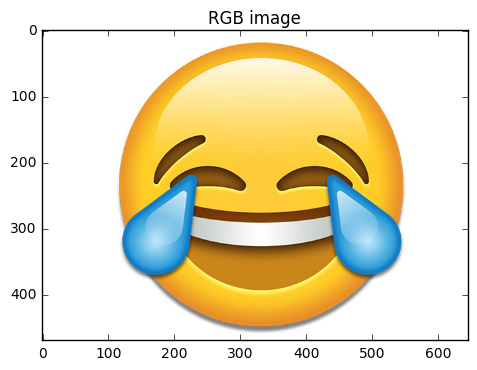

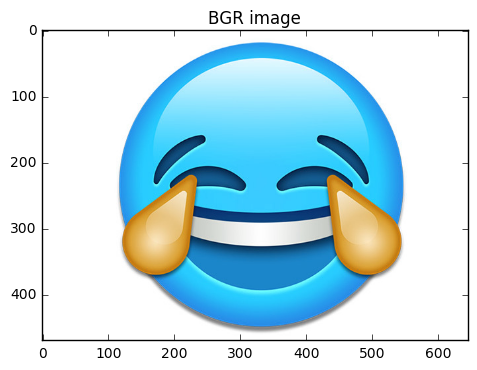

In [17]:
RGB_image = t_convolve_bank(image,np.array(bank_RGB))
plt.imshow(RGB_image, cmap=plt.cm.Greys_r)
plt.title("RGB image")
plt.show()

BGR_image = t_convolve_bank(image,bank_BGR)
plt.imshow(BGR_image, cmap=plt.cm.Greys_r)
plt.title("BGR image")
plt.show()

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг


При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

в математической статистике — число, характеризующее выборку (например, набор чисел). Если все элементы выборки различны, то медиана — это такое число выборки, что ровно половина из элементов выборки больше него, а другая половина меньше него. В более общем случае медиану можно найти, упорядочив элементы выборки по возрастанию или убыванию и взяв средний элемент. Например, выборка {11, 9, 3, 5, 5} после упорядочивания превращается в {3, 5, 5, 9, 11} и её медианой является число 5. Если в выборке чётное число элементов, медиана может быть не определена однозначно: для числовых данных чаще всего используют полусумму двух соседних значений (то есть медиану набора {1, 3, 5, 7} принимают равной 4)

In [18]:
def pool(poolfunc, image):
    assert(image.ndim == 3)
    new_a = []
    len_a = len(image)
    len_b = len(image[0])
    if len_a % 2 != 0:
        len_a -= 1
    if len_b % 2 != 0:
        len_b -= 1
    for i in xrange(0, len_a, 2):
        new_b = []
        for j in xrange(0, len_b, 2):
            new = np.zeros(3)
            for k in xrange(len(image[i][j])):
                new[k] = poolfunc(image[i][j][k],image[i][j+1][k],
                                  image[i+1][j][k],image[i+1][j+1][k])
            new_b.append(new)
        new_a.append(new_b)
    return np.array(new_a).astype("uint8")

def maxpool(image):
    poolfunc = lambda x,y,z,h: np.max(np.array([x,y,z,h]))
    return pool(poolfunc, image)

def medianpool(image):
    poolfunc = lambda x,y,z,h: np.median(np.array([x,y,z,h]))
    return pool(poolfunc, image)


Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

Шум соль и перец -- рвановероятые случайные чёрные и белые пиксели, появляющиеся на картинке с вероятностью alpha.

In [19]:
def solt_and_pepper(image, alpha = 0.05):
    noise_img = image.copy()
    BLACK = np.array([0,0,0]).astype("uint8")
    WHITE = np.array([255,255,255]).astype("uint8")
    for i in xrange(len(noise_img)):
        for j in xrange(len(noise_img[i])):
            if np.random.binomial(1,alpha):
                bw = np.random.binomial(1,0.5)
                if (bw) and not (noise_img[i][j] is WHITE):
                    noise_img[i][j] = WHITE
                else:
                    noise_img[i][j] = BLACK
    return noise_img.astype("uint8")

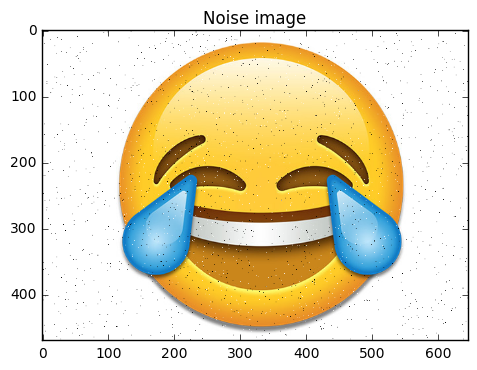

In [20]:
noise_img = solt_and_pepper(image, 0.01)

plt.imshow(noise_img)
plt.title("Noise image")
plt.show()

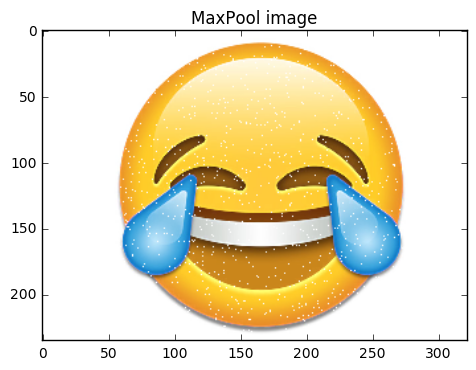

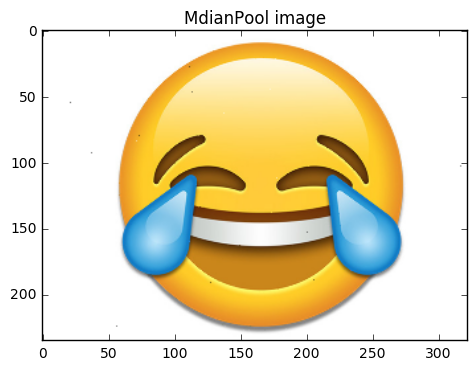

In [21]:
maxpool_image = maxpool(noise_img)
medianpool_image = medianpool(noise_img)

plt.imshow(maxpool_image)
plt.title("MaxPool image")
plt.show()

plt.imshow(medianpool_image)
plt.title("MdianPool image")
plt.show()

Хорошо видно, что медианный пулинг почти идеально справился с нашей задачей.

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST

In [34]:
from torch.autograd import Variable
from sklearn.metrics import classification_report

from timeit import default_timer as timer  
import torch

nn = torch.nn

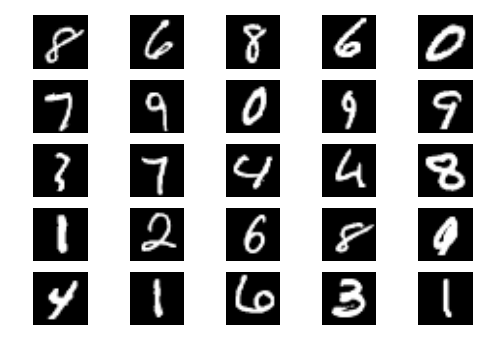

In [35]:

mnist = fetch_mldata('MNIST original')
images = mnist['data']
images = images.reshape(images.shape[0], 1, 28, 28)
labels = mnist['target'].astype(int)
np.random.seed(777)
images_train, images_test, labels_train, labels_test = train_test_split(images, labels)
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images_train[i, 0, :, :], cmap=plt.cm.Greys_r)
    plt.axis('off')
    
images_train = torch.from_numpy(images_train).type(torch.FloatTensor)
images_test = torch.from_numpy(images_test).type(torch.FloatTensor)
labels_train = torch.from_numpy(labels_train)
labels_test = torch.from_numpy(labels_test)

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 conv 3x3 -> ReLU -> maxpool -> 16 conv 3x3 -> softmax
1. input -> 8 conv 3x3 -> ReLU -> 16 conv 3x3 -> ReLU -> maxpool -> 32 conv 3x3 -> softmax

* nn.functional.conv2d
* nn.MaxPool2d
* nn.Reshape (чтобы перевести изображения в вектор)

Документация: http://pytorch.org/docs/

<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

In [114]:
# пример сверточной сети
import torch
from torch import nn
from torch.autograd import Variable

image_size = images_train.size(2)
channels = images_train.size(1)

class myConvNet(nn.Module):
    def __init__(self, 
                 conv_layers,
                 linear_layers,
                 loss_fn,
                 eps = 1e-35,
                 lr = 1e-4
                ):
        super(myConvNet, self).__init__()
        self.conv_layers = conv_layers
        self.linear_layers = linear_layers
        self.optimizer = torch.optim.Adam(self.parameters(), lr = lr) 
        self.loss_fn = loss_fn
        self.eps = eps
        self.losses = []
        self.errors = []
        self.error_items = []
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
    
    def timer(func):
        def wrapper(*args, **kwargs):
            start = timer()
            result = func(*args, **kwargs)
            end = timer()
            print("Calculation time: {} sec.".format(end - start))
            return result
        return wrapper
    
    @timer    
    def train(self,
              images_train, 
              labels_train, 
              max_iter_item = 50, 
              batch_size = 50):
        ''' 
        >>> train until the loss function stabilizes 
        '''
        counter = 0
        loss_pred = 1000 * self.eps
        loss_diff = 1000 * self.eps
        
        while  counter < max_iter_item: #and abs(loss_diff) > self.eps:
            
            for batch in xrange(0, images_train.size()[0], batch_size):
                X = Variable(images_train[batch : batch + batch_size])
                Y = Variable(labels_train[batch : batch + batch_size], requires_grad=False)
                output = self.forward(X)
            
                loss = self.loss_fn(output, Y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                loss_diff = loss_pred - loss.data[0] 
                loss_pred = loss.data[0]
                self.losses.append(loss.data[0])
                #if abs(loss_diff) < self.eps:
                #    break
            counter += 1
            print "Iteration #{0} is OK.".format(counter)
            
            
         
    def test(self, images, labels, number = 0, title = None, batch_size = 40):
        print "___________________TEST_#{}______________________".format(number)
        all_items = 0
        true_items = 0
        for batch in xrange(0, images.size()[0], batch_size):
            X = Variable(images[batch : batch + batch_size])
            Y = Variable(labels[batch : batch + batch_size], requires_grad=False)
            output = self.forward(X)
            res, ind = torch.max(output, 1)
            distance = (ind - Y).data.numpy()
            check = np.array([1 if abs(res.sum()) < 0.5 else 0 for res in distance])
            for i, elem in enumerate(check):
                if not elem:
                    self.errors.append(X[i])
                    self.error_items.append(Y[i])
            all_items += len(check)
            true_items += sum(check)
        print "{0} of {1} items identified correctly on {2}.".format(true_items,all_items, title)
        print "%.2lf%% items identified correctly."%(float(true_items) / float(all_items) * 100)
        print "________________________________________________"
        
    def mistakes(self):
        mistakes = {}
        for p in self.error_items:
            p = p.data.numpy()[0]
            if p in mistakes:
                mistakes[p] += 1
            else:
                mistakes[p] = 1
        report = sorted(mistakes.items(), key=lambda (k, v): v, reverse=True)
        print "Top mistakes:"
        for elem in report:
            print "{0} was wrong {1} times".format(elem[0],elem[1])
    
        print "Examples of unrecognized numbers:"
        imgs = np.array([p.data.numpy()[0] for p in self.errors[0:25]]) 
        imgs = imgs.reshape(imgs.shape[0], 1, 28, 28)
        for i in xrange(25):
            plt.subplot(5, 5, i+1)
            plt.imshow(imgs[i, 0, :, :], cmap=plt.cm.Greys_r)
            plt.axis('off')
        
    def plot(self,
             x, y,
             title = "Plot",
             xlabel = None,
             ylabel = None,
             grid  = True,
             save = False,
             name  = "plot.png",
            ):
        plt.plot(x,y)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.title(title)   
        plt.grid(grid)
        if save:
            plt.savefig(name)
        plt.show()
        plt.close()
        return self
    
    def losses_plot(self):
        steps = [i for i in xrange(len(self.losses))]
        self.plot(steps, self.losses, title = "Losses", xlabel = "steps", ylabel = "Losses on steps")



Iteration number 1 is OK.
Iteration number 2 is OK.
Iteration number 3 is OK.
Iteration number 4 is OK.
Iteration number 5 is OK.
Iteration number 6 is OK.
Iteration number 7 is OK.
Iteration number 8 is OK.
Iteration number 9 is OK.
Iteration number 10 is OK.
Iteration number 11 is OK.
Iteration number 12 is OK.
Iteration number 13 is OK.
Iteration number 14 is OK.
Iteration number 15 is OK.
Iteration number 16 is OK.
Iteration number 17 is OK.
Iteration number 18 is OK.
Iteration number 19 is OK.
Iteration number 20 is OK.
Iteration number 21 is OK.
Iteration number 22 is OK.
Iteration number 23 is OK.
Iteration number 24 is OK.
Iteration number 25 is OK.
Iteration number 26 is OK.
Iteration number 27 is OK.
Iteration number 28 is OK.
Iteration number 29 is OK.
Iteration number 30 is OK.
Iteration number 31 is OK.
Iteration number 32 is OK.
Iteration number 33 is OK.
Iteration number 34 is OK.
Iteration number 35 is OK.
Iteration number 36 is OK.
Iteration number 37 is OK.
Iteration 

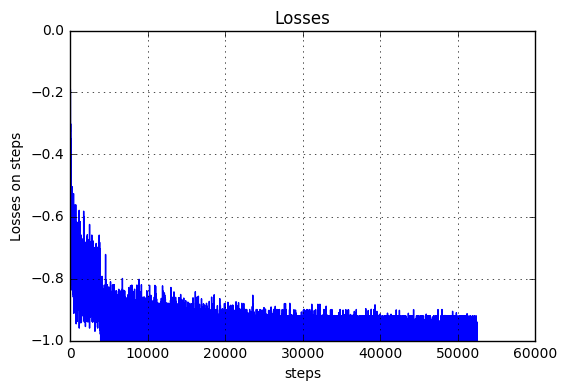

___________________TEST_#1______________________
51691 of 52500 items identified correctly on train sample.
98.46% items identified correctly.
________________________________________________
___________________TEST_#2______________________
17010 of 17500 items identified correctly on test sample.
97.20% items identified correctly.
________________________________________________
Top mistakes:
9 was wrong 245 times
8 was wrong 228 times
3 was wrong 166 times
7 was wrong 157 times
2 was wrong 134 times
5 was wrong 115 times
1 was wrong 75 times
4 was wrong 71 times
6 was wrong 60 times
0 was wrong 48 times
Examples of unrecognized numbers:


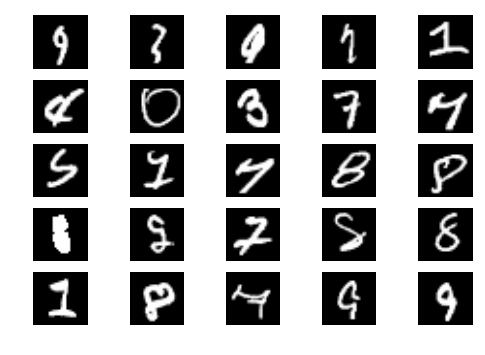

In [116]:
#input -> 8 conv 3x3 -> ReLU -> 16 conv 3x3 -> ReLU -> maxpool -> 32 conv 3x3 -> softmax
conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1), 
                            nn.ReLU(), 
                            nn.MaxPool2d(2),
                            nn.Conv2d(8, 16, 3, padding=1))

linear_layers = nn.Sequential(nn.Linear(image_size/2*image_size/2*16, 10), 
                              nn.Softmax())
network = myConvNet(conv_layers, linear_layers, loss_fn = torch.nn.NLLLoss())
network.train(images_train, labels_train)
network.losses_plot()
network.test(images_train, labels_train, 1, "train sample")
network.test(images_test, labels_test, 2, "test sample")
network.mistakes()

Iteration number 1 is OK.
Iteration number 2 is OK.
Iteration number 3 is OK.
Iteration number 4 is OK.
Iteration number 5 is OK.
Iteration number 6 is OK.
Iteration number 7 is OK.
Iteration number 8 is OK.
Iteration number 9 is OK.
Iteration number 10 is OK.
Iteration number 11 is OK.
Iteration number 12 is OK.
Iteration number 13 is OK.
Iteration number 14 is OK.
Iteration number 15 is OK.
Iteration number 16 is OK.
Iteration number 17 is OK.
Iteration number 18 is OK.
Iteration number 19 is OK.
Iteration number 20 is OK.
Iteration number 21 is OK.
Iteration number 22 is OK.
Iteration number 23 is OK.
Iteration number 24 is OK.
Iteration number 25 is OK.
Iteration number 26 is OK.
Iteration number 27 is OK.
Iteration number 28 is OK.
Iteration number 29 is OK.
Iteration number 30 is OK.
Iteration number 31 is OK.
Iteration number 32 is OK.
Iteration number 33 is OK.
Iteration number 34 is OK.
Iteration number 35 is OK.
Iteration number 36 is OK.
Iteration number 37 is OK.
Iteration 

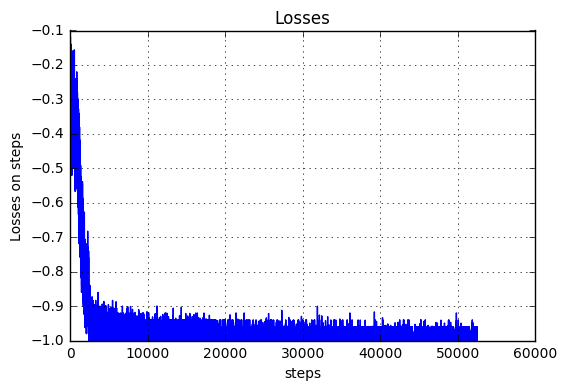

___________________TEST_#1______________________
52168 of 52500 items identified correctly on train sample.
99.37% items identified correctly.
________________________________________________
___________________TEST_#2______________________
17194 of 17500 items identified correctly on test sample.
98.25% items identified correctly.
________________________________________________
Top mistakes:
7 was wrong 139 times
3 was wrong 99 times
9 was wrong 83 times
8 was wrong 75 times
5 was wrong 66 times
4 was wrong 47 times
1 was wrong 45 times
2 was wrong 40 times
6 was wrong 30 times
0 was wrong 14 times
Examples of unrecognized numbers:


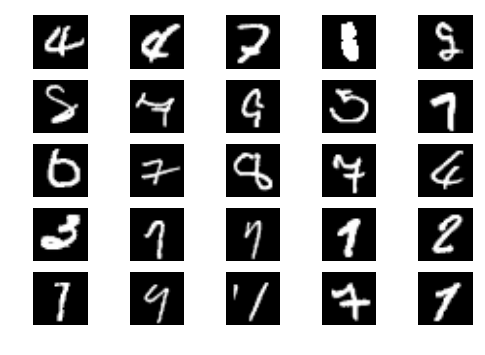

In [118]:
#input -> 8 conv 3x3 -> ReLU -> 16 conv 3x3 -> ReLU -> maxpool -> 32 conv 3x3 -> softmax
conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1), 
                            nn.ReLU(), 
                            nn.Conv2d(8, 16, 3, padding=1),
                            nn.ReLU(), 
                            nn.MaxPool2d(2),
                            nn.Conv2d(16, 32, 3, padding=1))

linear_layers = nn.Sequential(nn.Linear(image_size/2*image_size/2*32, 10), 
                              nn.Softmax())

network = myConvNet(conv_layers, linear_layers, loss_fn = torch.nn.NLLLoss())
network.train(images_train, labels_train)
network.losses_plot()
network.test(images_train, labels_train, 1, "train sample")
network.test(images_test, labels_test, 2, "test sample")
network.mistakes()

Отчётливо видно высокое качество обоих моделей, однако заметно, что вторая модель работает лучше, хоть и время обучения в несколько раз выше.

<i>3.2 На каких объектах сеть ошибается сильнее всего?</i>

Объекты, на которых наши модели ошибаются показаны в пунктах Top mistakes по принципу уменьшения частотности ошибок. Пример ошибочных картинок так же приведены ниже данного пункта. Можно заметить, что даже человеческим глазом не всегда можно с ходу распознать подобные числа.

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

Попробуем сэкономить время на более простой модели.

Iteration number 1 is OK.
Iteration number 2 is OK.
Iteration number 3 is OK.
Iteration number 4 is OK.
Iteration number 5 is OK.
Iteration number 6 is OK.
Iteration number 7 is OK.
Iteration number 8 is OK.
Iteration number 9 is OK.
Iteration number 10 is OK.
Iteration number 11 is OK.
Iteration number 12 is OK.
Iteration number 13 is OK.
Iteration number 14 is OK.
Iteration number 15 is OK.
Iteration number 16 is OK.
Iteration number 17 is OK.
Iteration number 18 is OK.
Iteration number 19 is OK.
Iteration number 20 is OK.
Iteration number 21 is OK.
Iteration number 22 is OK.
Iteration number 23 is OK.
Iteration number 24 is OK.
Iteration number 25 is OK.
Iteration number 26 is OK.
Iteration number 27 is OK.
Iteration number 28 is OK.
Iteration number 29 is OK.
Iteration number 30 is OK.
Iteration number 31 is OK.
Iteration number 32 is OK.
Iteration number 33 is OK.
Iteration number 34 is OK.
Iteration number 35 is OK.
Iteration number 36 is OK.
Iteration number 37 is OK.
Iteration 

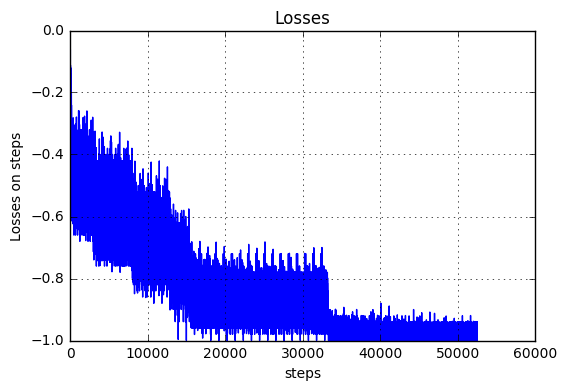

___________________TEST_#1______________________
52001 of 52500 items identified correctly on train sample.
99.05% items identified correctly.
________________________________________________
___________________TEST_#2______________________
17057 of 17500 items identified correctly on test sample.
97.47% items identified correctly.
________________________________________________
Top mistakes:
8 was wrong 158 times
7 was wrong 138 times
3 was wrong 136 times
9 was wrong 121 times
2 was wrong 95 times
4 was wrong 78 times
6 was wrong 65 times
5 was wrong 63 times
1 was wrong 58 times
0 was wrong 30 times
Examples of unrecognized numbers:


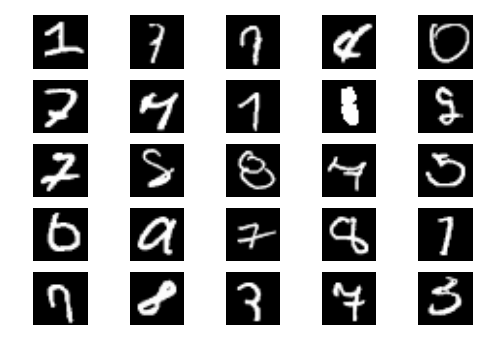

In [119]:
conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1), 
                            nn.ReLU(), 
                            nn.MaxPool2d(2))

linear_layers = nn.Sequential(nn.Linear(image_size/2*image_size/2*8, 10), 
                              nn.Softmax())
network = myConvNet(conv_layers, linear_layers, loss_fn = torch.nn.NLLLoss())
network.train(images_train, labels_train)
network.losses_plot()
network.test(images_train, labels_train, 1, "train sample")
network.test(images_test, labels_test, 2, "test sample")
network.mistakes()

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: